In [13]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

resolution = 10 # pixels/um

sx = 16  # size of cell in X direction
sy = 32  # size of cell in Y direction
cell = mp.Vector3(sx,sy,0)

dpml = 1.0
pml_layers = [mp.PML(dpml)]

In [14]:
pad = 1  # padding distance between waveguide and cell edge
w = 1    # width of waveguide

In [15]:
wvg_xcen =  0.5*(sx-w-2*pad)  # x center of horiz. wvg
wvg_ycen = -0.5*(sy-w-2*pad)  # y center of vert. wvg

In [16]:
geometry = [mp.Block(size=mp.Vector3(mp.inf,w,mp.inf),
                     center=mp.Vector3(0,wvg_ycen,0),
                     material=mp.Medium(epsilon=12))]

In [17]:
fcen = 0.15  # pulse center frequency
df = 0.1     # pulse width (in frequency)
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(-0.5*sx+dpml,wvg_ycen,0),
                     size=mp.Vector3(0,w,0))]


In [18]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

nfreq = 100  # number of frequencies at which to compute flux

# reflected flux
refl_fr = mp.FluxRegion(center=mp.Vector3(-0.5*sx+dpml+0.5,wvg_ycen,0), size=mp.Vector3(0,2*w,0))                            
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(center=mp.Vector3(0.5*sx-dpml,wvg_ycen,0), size=mp.Vector3(0,2*w,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

In [20]:
pt = mp.Vector3(0.5*sx-dpml-0.5,wvg_ycen)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,pt,1e-3))

# for normalization run, save flux fields data for reflection plane
straight_refl_data = sim.get_flux_data(refl)

field decay(t = 200.15): 9.825105984051625e-17 / 9.825105984051625e-17 = 1.0
field decay(t = 250.20000000000002): 4.115085979384511e-15 / 4.115085979384511e-15 = 1.0
field decay(t = 300.2): 3.1598263154800516e-15 / 4.115085979384511e-15 = 0.7678639842059055
field decay(t = 350.25): 1.000989143899876e-15 / 4.115085979384511e-15 = 0.24324865845199006
field decay(t = 400.3): 5.37218207192106e-16 / 4.115085979384511e-15 = 0.13054847696583416
field decay(t = 450.35): 1.3934186631836252e-15 / 4.115085979384511e-15 = 0.33861228420603673
field decay(t = 500.40000000000003): 1.402706424944705e-15 / 4.115085979384511e-15 = 0.340869287293605
field decay(t = 550.4): 1.059671159237058e-15 / 4.115085979384511e-15 = 0.2575088745522522
field decay(t = 600.45): 7.246459831523388e-16 / 4.115085979384511e-15 = 0.1760949799791846
field decay(t = 650.5): 3.283406930547674e-16 / 4.115085979384511e-15 = 0.07978950979388211
field decay(t = 700.5500000000001): 2.2528780737217156e-16 / 4.115085979384511e-15 = 0

In [21]:
straight_tran_flux = mp.get_fluxes(tran)

In [22]:
sim.reset_meep()

geometry = [mp.Block(mp.Vector3(sx-pad,w,mp.inf), center=mp.Vector3(-0.5*pad,wvg_ycen), material=mp.Medium(epsilon=12)),
            mp.Block(mp.Vector3(w,sy-pad,mp.inf), center=mp.Vector3(wvg_xcen,0.5*pad), material=mp.Medium(epsilon=12))]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran_fr = mp.FluxRegion(center=mp.Vector3(wvg_xcen,0.5*sy-dpml-0.5,0), size=mp.Vector3(2*w,0,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# for normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl, straight_refl_data)

pt = mp.Vector3(wvg_xcen,0.5*sy-dpml-0.5)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)


-----------
Initializing structure...
field decay(t = 50.050000000000004): 1.0712112480153345e-11 / 1.0712112480153345e-11 = 1.0
field decay(t = 100.05000000000001): 5.067000000543932e-07 / 5.067000000543932e-07 = 1.0
field decay(t = 150.1): 7.363526222864505e-07 / 7.363526222864505e-07 = 1.0
field decay(t = 200.15): 0.00504850579957142 / 0.00504850579957142 = 1.0
field decay(t = 250.20000000000002): 0.005818763912318551 / 0.005818763912318551 = 1.0
field decay(t = 300.2): 3.468840012126006e-09 / 0.005818763912318551 = 5.961472340856339e-07
run 0 finished at t = 300.2 (6004 timesteps)


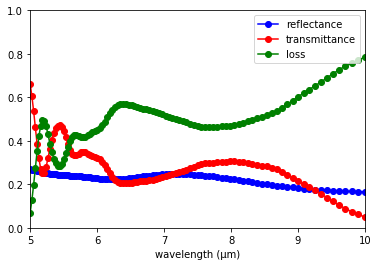

In [23]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1/flux_freqs[i])
    Rs = np.append(Rs,-bend_refl_flux[i]/straight_tran_flux[i])
    Ts = np.append(Ts,bend_tran_flux[i]/straight_tran_flux[i])    

if mp.am_master():
    plt.figure()
    plt.plot(wl,Rs,'bo-',label='reflectance')
    plt.plot(wl,Ts,'ro-',label='transmittance')
    plt.plot(wl,1-Rs-Ts,'go-',label='loss')
    plt.axis([5.0, 10.0, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()